In [114]:
#Import our dataset 
import pandas as pd
import numpy  as np
from ucimlrepo import fetch_ucirepo 
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV as RSCV
from sklearn.model_selection import GridSearchCV as GSCV
from sklearn.metrics import roc_curve, accuracy_score, recall_score , make_scorer, precision_score
#fetch dataset 
mushroom = fetch_ucirepo(id = 73) 
#data as pd dataframe 
X = mushroom.data.features 
Y = mushroom.data.targets 

#Global Random State: 
rng = 1312

## General dataframe handling / pre-processing 

### Missing values 
Missing values will olny be removed for the dataset aimed for the kNN, Random Forest can handle NAs.

In [102]:
X.isnull().values.any()
X.isnull().sum() 
#stalk-root has many missing values almost 1/3 of the total observations so we'll drop the variable.  
X_xn = X.drop('stalk-root',axis=1)  #X_xn:X without NAs
X_xn.isnull().sum() 

cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64

### Variable encoding 

In [130]:
#Let's find them binary vars first
binaries =[] 
c=1
for name in X_xn.columns: 
    var_amount = (X[name].unique())
    
    if len(var_amount) == 2 : 
        binaries.append(name) 
        #print (c, name, var_amount) 
    c+=1
print(binaries)
#Only #4,8,10,23 apear as binaries. Only bruises and edibility are true binaries the rest just happen to have only two categories. 
#If we had different dataset the other features might had different "non-binary" values. 

#Dataset, without missing values, one-hot encoded
X_enc = pd.get_dummies(X_xn, columns=list(X_xn.columns), dtype = int )
#Dataset, with missing values but with one-hot encoding
X_all  = pd.get_dummies(X, columns = list(X.columns), dtype = int) 

#### Create encoding for the RF algo 
var_dict = {}
feature_cat_dict = {} # the desired dictionary
for line in enumerate(list(mushroom.variables['description'])[1:]): 
    var_dict[X.columns[line[0]]] = (str(line[1]).split(","))    # Create adictionary to know where everything came from 
    v_dct = {}                    #second_layer dict
    for cat in enumerate(line[1].split(',')):

        v_dct[str(cat[1]).split("=")[1]]=cat[0]
        
    feature_cat_dict[X.columns[line[0]]] = v_dct 

#Dataset with missing values, simple encoded. 
Xc=X    
for column in (Xc.columns): 
    Xc[column] = Xc[column].replace(to_replace=feature_cat_dict[column])
    #print(feature_cat_dict[column])

#Target variable label encoding 
Y=pd.DataFrame(Y)
Y.isnull().values.any()             #false 
Y.groupby(by =["poisonous"]).size() #only two categories poisonous or edible 
Y=Y.replace(to_replace = { "e" : "0", "p" : "1"} )
Y = np.ravel(Y)                 #returns a contiguous array of the same subtype as input with shape input.size 

['bruises', 'gill-attachment', 'gill-spacing', 'gill-size', 'stalk-shape']


/tmp/ipykernel_171248/884060922.py:35: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



### ML_part 


In [111]:
#Split the data 
from sklearn.model_selection import train_test_split

#Dataset without missing values, one-hot encoded.  (kNN)
X_train,X_test, y_train, y_test = train_test_split(X_enc, Y , random_state = rng, test_size = 0.3 )

#Dataset with missing values, one-hot encoded. (Random forest)
Xme_train, Xme_test, yme_train, yme_test = train_test_split(X_all, Y, random_state = rng, test_size = 0.3 ) 

#Dataset with missing values, cat-encoding. (Ranfom Forest)
Xc_train, Xc_test, yc_train, yc_test = train_test_split(Xc, Y, random_state = rng, test_size = 0.3)


In [112]:
#Initiate logfile
with open("result_log.txt", "w") as f:
    f.write(" ")
    f.close()

## ROC curve plotting
ROC curves where used to visualize the difference in performance of the algorithms, but since all output produced labels rather than probabilities per label ROCs couldn't be applied in a meaning full way and were left out of the presentation and the report. 

In [113]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
def roc_plots(X_tests,y_tests,models,names,file=None):    #lists of test,validation datasets, model with parameters, names of the models 
    for  X_test, y_test, model,name in zip(X_tests, y_tests, models,names):
         
        y_pred = model.predict_proba(X_test)[:,1]
        fpr, tpr, thresholds = roc_curve(y_test.astype(int),y_pred.astype(int)) #thresholds is a byproduct...
        auc = round(roc_auc_score(y_test,y_pred),4)
        plt.plot(fpr,tpr, label = f'{name}, AUC=' + str(auc))
    plt.title('ROC curves for different classifiers', loc = 'left')
    plt.legend(loc = 'lower right')
    plt.savefig(file)

In [ ]:
y_pred = (clf_model.best_estimator_).predict_proba(Xc_test)[:, 1]
fpr, tpr, _ = roc_curve(yc_test.astype(int), y_pred.astype(int))
auc = round(roc_auc_score(yc_test, y_pred), 4)
plt.plot(fpr,tpr,label="full model, AUC="+str(auc))

y_pred = clf1.predict_proba(Xfl1_test)[:, 1]
fpr, tpr, _ = roc_curve(yfl1_test.astype(int), y_pred.astype(int))
auc = round(roc_auc_score(yfl1_test, y_pred), 4)
plt.plot(fpr,tpr,label="clf1, AUC="+str(auc))

y_pred = clf2.predict_proba(Xfl2_test)[:, 1]
fpr, tpr, _ = roc_curve(yfl2_test.astype(int), y_pred.astype(int))
auc = round(roc_auc_score(yfl2_test, y_pred), 4)
plt.plot(fpr,tpr,label="clf2, AUC="+str(auc))

plt.legend()

## Implementing Random Forest 
Since the estimator has native support for missing values, I'll use the X_m dataset. 

Tested initialy max_depth = 2 , 5 , 6 ,7 , 15. With max_depth = 7 we get already maximum accuracy

In [ ]:
#Hyperparameter optimization with Grid Search
import time
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV as GSCV


start_time = time.time()
parameters_to_test = {'n_estimators' : np.arange(50, 70, 100), 
                      'max_depth' : [3, 5, 7, 9],
                      'max_features' : np.arange(0.1, 1), 
                      'max_samples' : [0.5, 0.7]}

clf_model = GSCV(RandomForestClassifier(), parameters_to_test, cv = 5, scoring = 'accuracy', n_jobs = -1)
clf_model.fit(Xc_train, yc_train)

clf_model_pred = clf_model.predict(Xc_test)
train_pred = clf_model.predict(Xc_train)
end_time = time.time()

print(f'Accuracy for model by GSCV: {accuracy_score(clf_model_pred,yc_test)}')
print(f'Accuracy for train data: {accuracy_score(train_pred,yc_train)}')
print(f'Test data: Recall: {round(recall_score(yc_test.astype(int),clf_model_pred.astype(int)),4)} , Precision: {round(precision_score(yc_test.astype(int),clf_model_pred.astype(int)),4)}')

print(f"Best parameters: {clf_model.best_params_}")
print(f"Best CV score: {clf_model.best_score_}")
print(f'Execution time: {round(end_time - start_time ,5)} sec')

with open ('result_log.txt', 'a') as file:
    file.write(f'GSCV RF model\n'
                f'Accuracy for model by GSCV: {accuracy_score(clf_model_pred,yc_test)}\n'
                f'Accuracy for train data: {accuracy_score(train_pred,yc_train)}\n'
                f'Test data: Recall: {round(recall_score(yc_test.astype(int),clf_model_pred.astype(int)),4)} , Precision: {round(precision_score(yc_test.astype(int),clf_model_pred.astype(int)),4)}\n'
                f"Best parameters: {clf_model.best_params_}\n"
                f"Best CV score: {clf_model.best_score_}\n"
                f'Execution time: {round(end_time - start_time ,5)} sec\n\n')
    file.close()

Accuracy for model by GSCV: 1.0
Accuracy for train data: 1.0
Test data: Recall: 1.0 , Precision: 1.0
Best parameters: {'max_depth': 7, 'max_features': np.float64(0.1), 'max_samples': 0.7, 'n_estimators': np.int64(50)}
Best CV score: 1.0
Execution time: 2.14903 sec


#### Feature importance and selection 
for the plotting check this too: https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py


In [124]:
#Function 
import matplotlib.pyplot as plt 
def feat_importance_plot_mdi (DF,model,file=None) : #Feature Importance based on impurity
    feature_names = DF.columns
    
    importances = model.feature_importances_ 
    std = np.std([tree.feature_importances_ for tree in model.estimators_], axis = 0 ) 

    indices = np.argsort(importances)[::-1]
    print("Feature ranking:")
    for f in range(DF.shape[1]):
        print("%d.feature %d (*%s) :(%f)" % (f+1, indices[f], DF.columns[f], importances[indices[f]]))  

    #Plot the same values: 
    rf_importances = pd.Series(importances, index = feature_names) # beware which feature names to use 
    fig, ax = plt.subplots() 
    rf_importances.plot.bar(yerr = std, ax = ax) 
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()
    plt.savefig(file)

def feat_importance_plot_perm(DF, model, xtest, ytest, file=None) : #Feature importane plot based on permutation
    from sklearn.inspection import permutation_importance 
    feature_names = DF.columns
    start_time = time.time() 
    
    fibp = permutation_importance(model, xtest, ytest, n_repeats = 10,random_state = rng) 
    runtime = time.time() - start_time 
    print(f"Elapsed time to compute the permutation importances: {runtime:.3f} seconds") 
    rf_importances = pd.Series(fibp.importances_mean, index= feature_names)
    print(rf_importances)
    fig, ax = plt.subplots() 
    rf_importances.plot.bar(yerr = fibp.importances_std, ax = ax) 
    ax.set_title(f"Feature importances using permutation on full model.")
    ax.set_ylabel("Mean accuracy decrease ")
    fig.tight_layout() 
    plt.savefig(file)
    

Feature ranking:
1.feature 19 (*cap-shape) :(0.146104)
2.feature 4 (*cap-surface) :(0.110063)
3.feature 7 (*cap-color) :(0.087033)
4.feature 18 (*bruises) :(0.079787)
5.feature 11 (*odor) :(0.068320)
6.feature 20 (*gill-attachment) :(0.064786)
7.feature 3 (*gill-spacing) :(0.062123)
8.feature 10 (*gill-size) :(0.053971)
9.feature 12 (*gill-color) :(0.048377)
10.feature 21 (*stalk-shape) :(0.046299)
11.feature 8 (*stalk-root) :(0.039550)
12.feature 6 (*stalk-surface-above-ring) :(0.036475)
13.feature 13 (*stalk-surface-below-ring) :(0.032080)
14.feature 14 (*stalk-color-above-ring) :(0.023243)
15.feature 9 (*stalk-color-below-ring) :(0.022302)
16.feature 1 (*veil-type) :(0.021653)
17.feature 17 (*veil-color) :(0.019857)
18.feature 2 (*ring-number) :(0.013215)
19.feature 0 (*ring-type) :(0.011072)
20.feature 16 (*spore-print-color) :(0.010349)
21.feature 5 (*population) :(0.003340)
22.feature 15 (*habitat) :(0.000000)


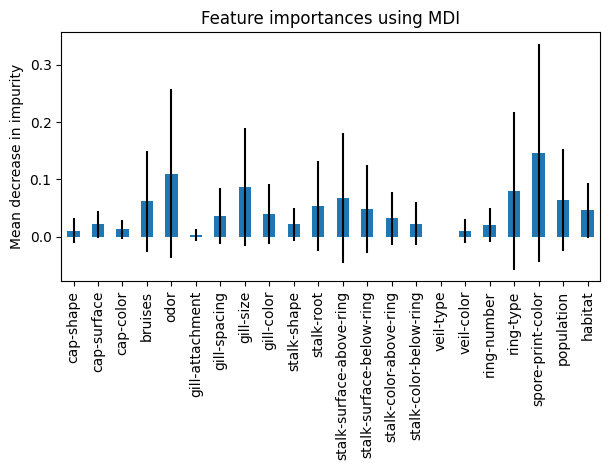

In [ ]:
#Feature Importance with MDI
feat_importance_plot_mdi(Xc, clf_model.best_estimator_,file='mdi_features.png')


Elapsed time to compute the permutation importances: 1.523 seconds
cap-shape                   0.000000
cap-surface                 0.002297
cap-color                   0.000000
bruises                     0.003117
odor                        0.001025
gill-attachment             0.000000
gill-spacing                0.000246
gill-size                   0.014028
gill-color                  0.001313
stalk-shape                 0.000000
stalk-root                  0.000000
stalk-surface-above-ring    0.000000
stalk-surface-below-ring    0.000082
stalk-color-above-ring      0.000000
stalk-color-below-ring      0.000451
veil-type                   0.000000
veil-color                  0.000000
ring-number                 0.000000
ring-type                   0.000164
spore-print-color           0.004061
population                  0.000492
habitat                     0.001805
dtype: float64


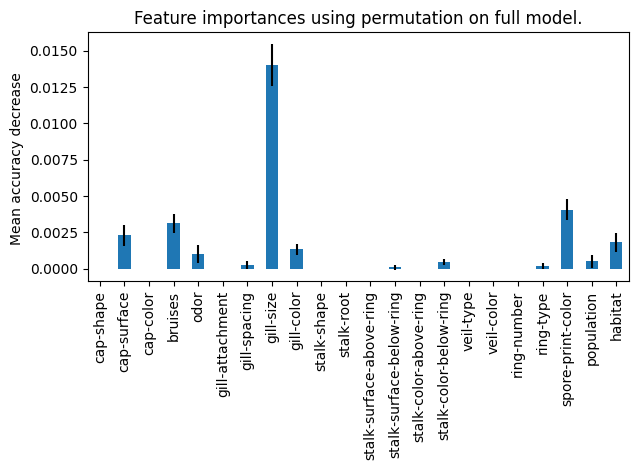

In [ ]:
#Feature Importance with Permutations
feat_importance_plot_perm(Xc, clf_model.best_estimator_, Xc_test, yc_test, file='perm_features.png')

In [132]:
#Based on feature importance plotting I do compare efficacy of the full model vs 2 models with selected features only. 
# -> Selected features from Perm_importance  odor, spore-print-color, gill-size, habitat, bruises
# -> Selected features from Impurity based importance  : cap-shape, cap-color, cap-surface, odor, bruises 
import time 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score 


X_fless_mdi = Xc[['cap-shape','cap-color', 'cap-surface', 'odor', 'bruises']]
Xfl1_train, Xfl1_test, yfl1_train, yfl1_test = train_test_split(X_fless_mdi, Y, random_state = rng, test_size = 0.3)    #featureless1

X_fless_perm = Xc[['odor', 'spore-print-color', 'gill-size','habitat', 'bruises']]
Xfl2_train, Xfl2_test, yfl2_train, yfl2_test = train_test_split(X_fless_perm, Y, random_state = rng, test_size = 0.3)   #featureless2

#testing RF models with different parameters
clf1 = RandomForestClassifier(max_depth=7,max_features=0.1,max_samples=0.5,n_estimators=50)    #MDI
clf2 = RandomForestClassifier(max_depth=7,max_features=0.1,max_samples=0.5,n_estimators=50)    #PERM
#fitting the models to the data
start_time = time.time()
clf1.fit(Xfl1_train,yfl1_train)
clf2.fit(Xfl2_train,yfl2_train) 

#Try the cross validation process

scores_clf1 = cross_val_score(clf1, Xfl1_train, yfl1_train, cv = 5, scoring = 'accuracy')
scores_clf2 = cross_val_score(clf2, Xfl2_train, yfl2_train, cv = 5, scoring = 'accuracy')

#Predicting outcome for the test data 
clf1_pred = clf1.predict(Xfl1_test)
clf2_pred = clf2.predict(Xfl2_test) 
#Calculating different scores
clf1_test_score = accuracy_score(clf1_pred,yfl1_test)
clf2_test_score = accuracy_score(clf2_pred,yfl2_test)
#Recall
clf1_recall = recall_score(yfl1_test.astype(int),clf1_pred.astype(int))
clf2_recall = recall_score(yfl2_test.astype(int),clf2_pred.astype(int))
#Precision
clf1_precision = precision_score(yfl1_test.astype(int),clf1_pred.astype(int))
clf2_precision = precision_score(yfl2_test.astype(int),clf2_pred.astype(int)) 

end_time = time.time()
print(f"Score\nMDI: {scores_clf1} \n PERM: {scores_clf2}")
print(f"Mean accuracy Feature Reduction\nMDI: {round(scores_clf1.mean(),4)} PERM: {round(scores_clf2.mean(),4)}") 
print(f"Test Accuracy\nMDI: {round(clf1_test_score,4)} PERM: {round(clf2_test_score,4)}")
print(f"Test Recall; MDI: {round(clf1_recall,4)} PERM: {round(clf2_recall,4)}")
print(f"Precision; MDI: {round(clf1_precision,4)} PERM: {round(clf2_precision,4)}")
print(f'Execution time: {round(end_time - start_time ,5)} sec')

with open("result_log.txt","a") as file: 
    file.write(f"RF classifier results after Feature selection based on importances\n"
        f"MDI variables: {X_fless_mdi.columns[0:]}\nPERM variables: {X_fless_perm.columns[0:]}\n"
        f"Score\nMDI: {scores_clf1} \n PERM: {scores_clf2}\n"
        f"Mean accuracy Feature Reduction\nMDI: {round(scores_clf1.mean(),4)} PERM: {round(scores_clf2.mean(),4)}\n"
        f"Test Accuracy\nMDI: {round(clf1_test_score,4)} PERM: {round(clf2_test_score,4)}\n"
        f"Test Recall; MDI: {round(clf1_recall,4)} PERM: {round(clf2_recall,4)}\n"
        f"Precision; MDI: {round(clf1_precision,4)} PERM: {round(clf2_precision,4)}\n"
        f'Execution time: {round(end_time - start_time ,5)} sec\n\n')
    file.close()


Score
MDI: [0.99121265 0.99472296 0.99560246 0.99648197 0.99560246] 
 PERM: [0.99912127 1.         1.         0.99736148 0.99824099]
Mean accuracy Feature Reduction
MDI: 0.9947 PERM: 0.9989
Test Accuracy
MDI: 0.9938 PERM: 0.9992
Test Recall; MDI: 0.9873 PERM: 0.9983
Precision; MDI: 1.0 PERM: 1.0
Execution time: 0.5989 sec


### ROC plot for all RF models

In [ ]:
#ROC data for Random Forest and Random Forest after 2 different feature selections. 
#y_predictions,y_tests,models
#Adding Feature-less efficacy score to AUC plot: 
X_tsts = [Xc_test,Xfl1_test,Xfl2_test]
y_ts = [yc_test,yfl1_test,yfl2_test]
ms = [clf_model.best_estimator_,clf1,clf2] 
names = ['RF_full', 'RF_FeatSel_MDI', 'RF_FeatSel_PERM']
roc_plots(X_tsts,y_ts,ms,names,file='ROC_rf_models.png')

### Implementing k-Nearest Neighbors classification 
with Neighbor Component Analysis, non-supportive for missing values  

K 	 training 	 test 	 C-V_mean_accuracy 	Precision 	Recall

K = 2 : 100.00%		100.00%		100.00%		100.00%t	100.00%
K = 3 : 100.00%		100.00%		100.00%		100.00%t	100.00%
K = 4 : 100.00%		100.00%		100.00%		100.00%t	100.00%
K = 5 : 100.00%		100.00%		100.00%		100.00%t	100.00%
K = 6 : 100.00%		100.00%		100.00%		100.00%t	100.00%
K = 7 : 100.00%		100.00%		100.00%		100.00%t	100.00%
K = 8 : 99.98%		100.00%		100.00%		100.00%t	100.00%
K = 9 : 99.98%		100.00%		100.00%		100.00%t	100.00%
K = 10 : 99.98%		100.00%		99.99%		100.00%t	100.00%


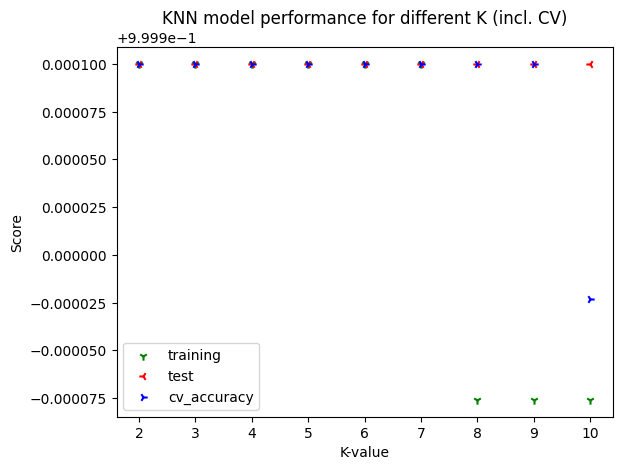

<Figure size 640x480 with 0 Axes>

In [133]:
#Finding the best K KNN
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.model_selection import KFold, cross_val_score
#Hyperparameter tuning
K = []
training = [] 
test = []
scores = {} 
accuracy = []
    # from cross validation
for k in range (2,11): 
    clsf = KNeighborsClassifier(n_neighbors=k) 
    clsf.fit(X_train, y_train) 

    training_score = clsf.score(X_train, y_train) 
    test_score = clsf.score(X_test, y_test) 
    training.append(training_score) 
    test.append(test_score) 
    K.append(k) 
    

    kf = KFold(n_splits = 5, shuffle = True, random_state = rng)        #Cross Validation over 5 splits. 
    cross_val_results = cross_val_score(KNeighborsClassifier(n_neighbors=k), X_enc, Y, cv = kf) 
    accuracy_cv = cross_val_results.mean()
    accuracy.append(accuracy_cv)
    
    accuracy_test = clsf.score(X_test, y_test) 
    ypred = clsf.predict(X_test)
    recall = recall_score(y_test.astype(int), ypred.astype(int))
    precision = precision_score(y_test.astype(int), ypred.astype(int))

    scores[k] = [training_score,test_score, accuracy_cv, precision , recall] 

#print("K \t training \t test \t C-V_mean_accuracy \tPrecision \tRecall")
#print(line)
with open('result_log.txt',"a") as file:
    file.write(f"KNN model with CV\n"
        f"K \t training \t test \t C-V_mean_accuracy \tPrecision \tRecall\n") 
    print(f"K \t training \t test \t C-V_mean_accuracy \tPrecision \tRecall\n")
    for key, value in scores.items() : 
        print(f"K = {key} : {value[0]*100:.2f}%\t\t{value[1]*100:.2f}%\t\t{value[2]*100:.2f}%\t\t{value[3]*100:.2f}%t\t{value[4]*100:.2f}%") 
        file.write(f"K = {key} : {value[0]*100:.2f}%\t\t{value[1]*100:.2f}%\t\t{value[2]*100:.2f}%\t\t{value[3]*100:.2f}%t\t{value[4]*100:.2f}%\n")
    file.write("\n\n")

#Plotting different K performances
import seaborn as sns 
import matplotlib.pyplot as plt 
plt.scatter(K,training, color ='g', label = 'training', marker = "1") 
plt.scatter(K,test, color = 'r', label = 'test', marker = "3") 
plt.scatter(K,accuracy, color = 'b', label = 'cv_accuracy', marker = "4")
plt.xlabel("K-value")
plt.ylabel("Score") 
plt.title("KNN model performance for different K (incl. CV)")
plt.legend()
plt.show() 
plt.savefig("KNN_model_performance_per_K.png")

In [134]:
#Finding the best K KNN with NCA and cross-validation 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, KFold 
from sklearn.neighbors import NeighborhoodComponentsAnalysis as NCA

nca = NCA(random_state = rng) 

K= range(2,11) 
cv = KFold(n_splits  = 5, random_state = rng, shuffle = True) 
nca_scores = [] 

print(f"Κ \t Mean CV accuracy(train) \tAccuracy score(test) \tPrecision \tRecall") 
with open('result_log.txt','a') as file: 
    file.write(f"kNN model NCA CV\n"
                f"Κ \t Mean CV accuracy(train) \tAccuracy score(test) \tPrecision \tRecall\n")
    file.close()
for k in K :
    model = Pipeline([
        ('nca', NCA(random_state=rng)),
        ('knn', KNeighborsClassifier(n_neighbors = k ) ) ]) 

    scores = cross_val_score (model, X_train, y_train, cv = cv, scoring = 'accuracy') 
    model.fit(X_train,y_train)
    #As scoraroume
    accuracy_test = model.score(X_test, y_test) 
    ypred = model.predict(X_test) 
    recall = recall_score(y_test.astype(int), ypred.astype(int))
    precision = precision_score(y_test.astype(int), ypred.astype(int))
    print(f"K = {k} : \t{scores.mean()*100:.3f}%\t\t{accuracy_test * 100:.3f}%\t\t{precision *100:.3f}%\t\t{recall *100:.3f}%")
    nca_scores.append(scores.mean()) 
    with open('result_log.txt','a') as file: 
        file.write(
                    f"K = {k} : {scores.mean()*100:.3f}%\t\t{accuracy_test * 100:.3f}%\t\t{precision *100:.3f}%\t\t{recall *100:.3f}%\n")
        file.close()


Κ 	 Mean CV accuracy(train) 	Accuracy score(test) 	Precision 	Recall
K = 2 : 	100.000%		100.000%		100.000%		100.000%
K = 3 : 	100.000%		100.000%		100.000%		100.000%
K = 4 : 	99.965%		100.000%		100.000%		100.000%
K = 5 : 	99.965%		100.000%		100.000%		100.000%
K = 6 : 	99.930%		100.000%		100.000%		100.000%
K = 7 : 	99.965%		100.000%		100.000%		100.000%
K = 8 : 	99.930%		99.877%		100.000%		99.747%
K = 9 : 	99.965%		99.877%		100.000%		99.747%
K = 10 : 	99.965%		99.877%		100.000%		99.747%


In [ ]:
#Model implementation kNN for the chosen K
import time
clsf_knn = KNeighborsClassifier(n_neighbors=3) 
clsf.fit(X_train, y_train) 
training_score = clsf.score(X_train, y_train) 
test_score = clsf.score(X_test, y_test) 
pred_knn = clsf.predict(X_test) 
print(training_score, test_score)

0.9998241294407316 1.0 ['1' '0' '1' ... '1' '1' '1']


## ROC for all models 

In [ ]:
 
roc_plots([X_test],[y_test],[clsf_knn.fit(X_train,y_train)],['kNN classifier'], file='kNN_classifier.png')

In [ ]:
X_tsts = [Xc_test,Xfl1_test,Xfl2_test,X_test]
y_ts = [yc_test,yfl1_test,yfl2_test,y_test]
ms = [clf_model.best_estimator_,clf1,clf2,clsf_knn.fit(X_train,y_train)] 
names = ['RF_full', 'RF_FeatSel_MDI', 'RF_FeatSel_PERM','kNN']
roc_plots(X_tsts,y_ts,ms,names,file='roc_all_classifiers.png')